# 安裝 SHAP 套件

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# 安裝一些必要套件

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Step 1：資料理解與探索性分析（EDA）

欄位名稱	 說明

|----------|--------------|

datetime	時間戳（每小時）

season	季節（1:春, 2:夏, 3:秋, 4:冬）

holiday	是否為假日（0/1）

workingday	是否為工作日（週末與假日為0）

weather	天氣狀況（1-4，數字越大天氣越差）

temp	攝氏溫度（實際溫度）

atemp	體感溫度

humidity	濕度（%）

windspeed	風速

casual	非註冊使用者租借數

registered	註冊使用者租借數

count	總租借數（casual + registered）

In [2]:
df = pd.read_csv("train.csv", parse_dates=["dteday"])
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     15919 non-null  int64         
 1   dteday      15919 non-null  datetime64[ns]
 2   season      15919 non-null  int64         
 3   yr          15919 non-null  int64         
 4   mnth        15919 non-null  int64         
 5   hr          15919 non-null  int64         
 6   holiday     15919 non-null  int64         
 7   weekday     15919 non-null  int64         
 8   workingday  15919 non-null  int64         
 9   weathersit  15919 non-null  int64         
 10  temp        15919 non-null  float64       
 11  atemp       15919 non-null  float64       
 12  hum         15919 non-null  float64       
 13  windspeed   15919 non-null  float64       
 14  cnt         15919 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(10)
memory usage: 1.8 MB
None


每日總租借數時間序列

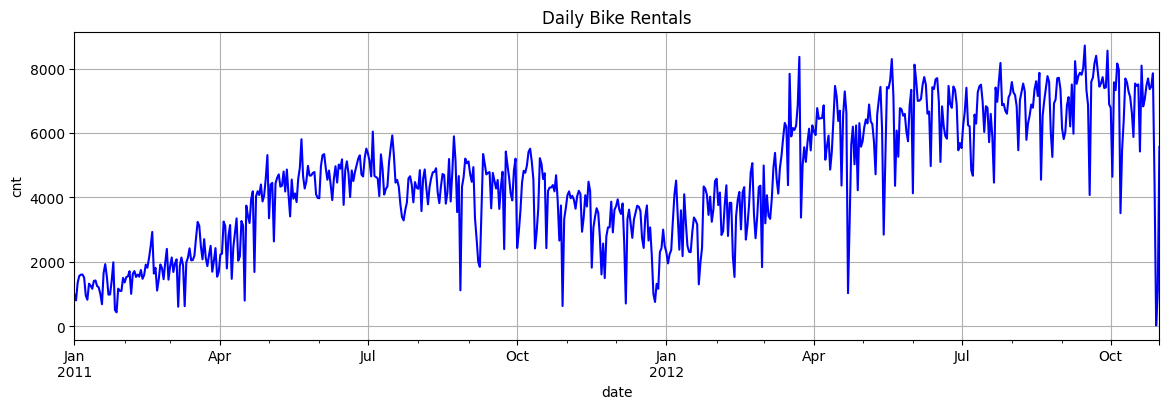

In [3]:
df["date"] = df["dteday"]
daily = df.groupby("date")["cnt"].sum()

plt.figure(figsize=(14, 4))
daily.plot(title="Daily Bike Rentals", color="blue", label="cnt")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

每日總租借量趨勢

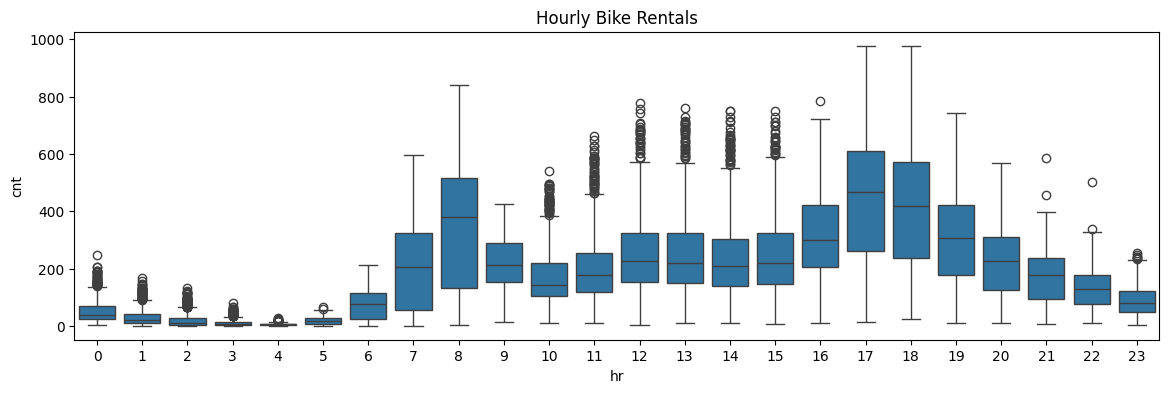

In [4]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="hr", y="cnt")
plt.title("Hourly Bike Rentals")
plt.show()

每星期幾租借量分布

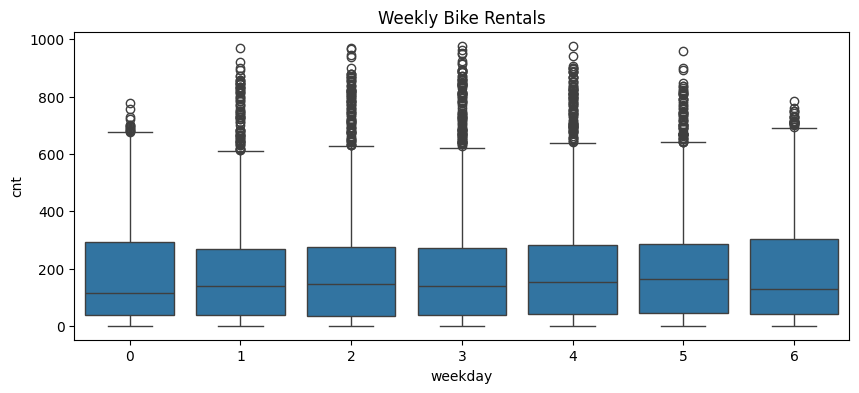

In [5]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="weekday", y="cnt")
plt.title("Weekly Bike Rentals")
plt.show()

每月租借量分布

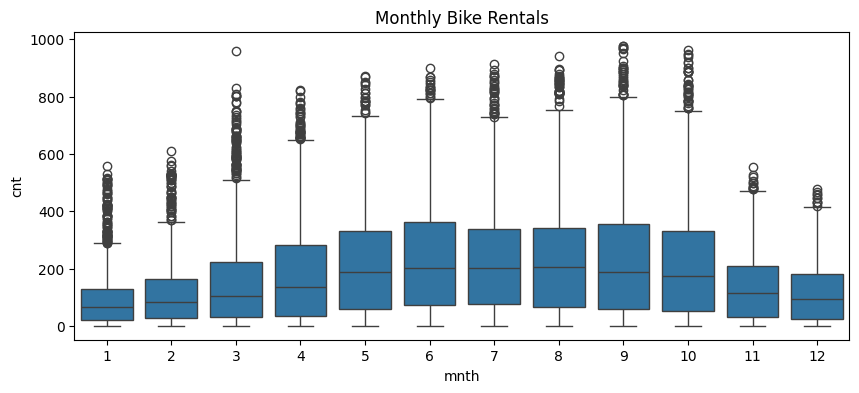

In [6]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="mnth", y="cnt")
plt.title("Monthly Bike Rentals")
plt.show()

類別欄位與 cnt 的關係

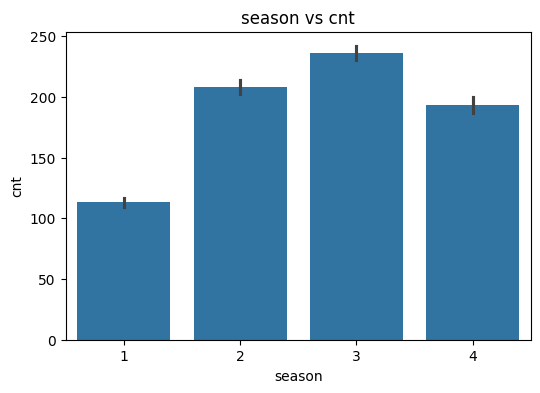

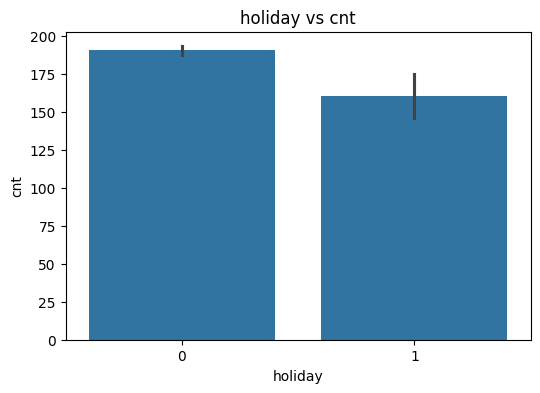

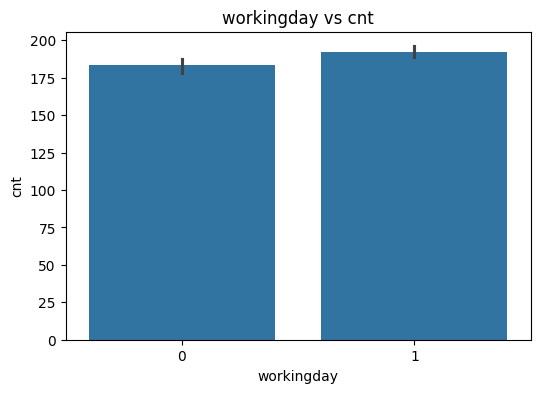

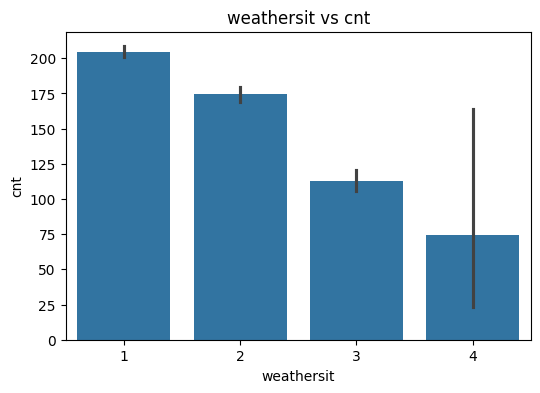

In [7]:
categorical_cols = ["season", "holiday", "workingday", "weathersit"]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x=col, y="cnt")
    plt.title(f"{col} vs cnt")
    plt.show()

數值特徵與 cnt 的相關性

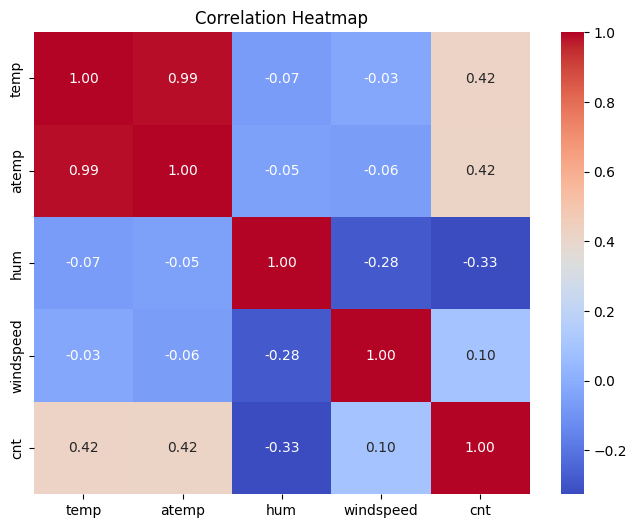

In [8]:
numeric_features = ["temp", "atemp", "hum", "windspeed", "cnt"]
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Step 2：特徵工程與資料前處理

In [3]:
# === 原始資料讀取 ===
df = pd.read_csv("train.csv", parse_dates=["dteday"])
df['date'] = df['dteday']

# === 加入週期性與交互特徵 ===
df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
df['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
df['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)

df['hr_x_weekday'] = df['hr'] * df['weekday']
df['hr_x_workingday'] = df['hr'] * df['workingday']
df['temp_x_hum'] = df['temp'] * df['hum']
df['atemp_x_wind'] = df['atemp'] * df['windspeed']

# === 特徵選擇 ===
selected_features = [
    'season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed',
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
    'hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind'
]

categorical_features = ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed',
                      'hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind']

df_encoded = pd.get_dummies(df[selected_features], columns=categorical_features, drop_first=False)

# === 正規化數值欄位 ===
scaler = MinMaxScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# === 加上目標與時間欄位 ===
df_encoded['cnt'] = df['cnt']
df_encoded['date'] = df['date']

# === 儲存欄位順序（給推理用）===
feature_names = df_encoded.drop(columns=["cnt", "date"]).columns.tolist()
np.save("feature_names.npy", feature_names)

# === 儲存資料 ===
df_encoded.to_csv("processed_train_33feat.csv", index=False)
print(f"處理後特徵數量: {df_encoded.shape[1] - 2}")


處理後特徵數量: 33


# Step 3：建立 Sliding Window 資料集

In [4]:
def create_sliding_window_dataset(df, window_size=24, log_transform=True, start_idx=0):
    assert "cnt" in df.columns and "date" in df.columns, "需要包含 cnt 與 date 欄位"
    
    feature_columns = [col for col in df.columns if col not in ["cnt", "date"]]
    features = df[feature_columns].values
    targets = np.log1p(df["cnt"].values) if log_transform else df["cnt"].values
    times = df["date"].values

    X, y, X_time = [], [], []

    for i in range(start_idx + window_size, len(df)):
        X.append(features[i - window_size:i])
        y.append(targets[i])
        X_time.append(times[i])

    X = np.array(X)
    y = np.array(y)
    X_time = np.array(X_time)

    print(f"Total samples: {len(X)}, Feature dim: {X.shape[-1]}, Window size: {window_size}")
    return X, y, X_time, feature_columns

# Step 4：LSTM 模型建構與訓練流程

資料分割

In [5]:
# 讀入資料
df_processed = pd.read_csv("processed_train_33feat.csv", parse_dates=["date"])

# 建立資料集
X, y, X_time, feature_names = create_sliding_window_dataset(df_processed, window_size=24, log_transform=True)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# 訓練 / 驗證切分
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]
X_time_train, X_time_val = X_time[:split_idx], X_time[split_idx:]

# 印出資訊
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print(f"訓練時間範圍: {X_time_train[0]} ~ {X_time_train[-1]}")
print(f"驗證時間範圍: {X_time_val[0]} ~ {X_time_val[-1]}")


Total samples: 15895, Feature dim: 33, Window size: 24
X_train shape: (12716, 24, 33)
y_train shape: (12716,)
X_val shape: (3179, 24, 33)
y_val shape: (3179,)
訓練時間範圍: 2011-01-02T00:00:00.000000000 ~ 2012-06-20T00:00:00.000000000
驗證時間範圍: 2012-06-20T00:00:00.000000000 ~ 2012-10-31T00:00:00.000000000


Dataset 類別定義和 LSTM 架構

In [6]:
class BikeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # out: (B, T, H)
        out = out[:, -1, :]           # 取最後一個時間步
        out = self.fc(out)            # 預測一個值
        return F.softplus(out)        # 可改成 ReLU 或不加

DataLoader

In [7]:
# 1. 建立 Dataset
train_dataset = BikeDataset(X_train, y_train)
val_dataset = BikeDataset(X_val, y_val)

# 2. 建立 DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

使用 RMSLE Loss 訓練

In [8]:
def rmsle_loss_log_space(pred_log, target_log):
    return torch.sqrt(torch.mean((pred_log - target_log) ** 2))

In [11]:
# --- 初始化 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=X.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

EPOCHS = 300
patience = 100
best_val_loss = float('inf')
no_improve_epochs = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1:03d}]", leave=False)
    for xb, yb in train_bar:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = rmsle_loss_log_space(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_train_loss += loss.item() * len(xb)
        train_bar.set_postfix(loss=loss.item())

    # === 驗證 ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_val_loss += rmsle_loss_log_space(pred, yb).item() * len(xb)


    # === 平均 loss ===
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # === 模型儲存 ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print("✅ Best model saved.")
    else:
        no_improve_epochs += 1
        print(f"🔁 No improvement ({no_improve_epochs}/{patience})")

    # === 更新學習率 ===
    scheduler.step(avg_val_loss)

    # === Early stopping ===
    if no_improve_epochs >= patience:
        print("🛑 Early stopping triggered.")
        break


Epoch 001 | Train Loss: 2.7945 | Val Loss: 1.5130
✅ Best model saved.


Epoch 002 | Train Loss: 1.3875 | Val Loss: 1.4489
✅ Best model saved.


Epoch 003 | Train Loss: 1.2087 | Val Loss: 0.9015
✅ Best model saved.


Epoch 004 | Train Loss: 0.6957 | Val Loss: 0.6680
✅ Best model saved.


Epoch 005 | Train Loss: 0.6102 | Val Loss: 0.5798
✅ Best model saved.


Epoch 006 | Train Loss: 0.5670 | Val Loss: 0.5371
✅ Best model saved.


Epoch 007 | Train Loss: 0.5416 | Val Loss: 0.5107
✅ Best model saved.


Epoch 008 | Train Loss: 0.5236 | Val Loss: 0.4985
✅ Best model saved.


Epoch 009 | Train Loss: 0.5036 | Val Loss: 0.4298
✅ Best model saved.


Epoch 010 | Train Loss: 0.4853 | Val Loss: 0.4226
✅ Best model saved.


Epoch 011 | Train Loss: 0.4682 | Val Loss: 0.3939
✅ Best model saved.


Epoch 012 | Train Loss: 0.4550 | Val Loss: 0.3771
✅ Best model saved.


Epoch 013 | Train Loss: 0.4445 | Val Loss: 0.3939
🔁 No improvement (1/100)


Epoch 014 | Train Loss: 0.4399 | Val Loss: 0.3649
✅ Best model saved.


Epoch 015 | Train Loss: 0.4317 | Val Loss: 0.3586
✅ Best model saved.


Epoch 016 | Train Loss: 0.4248 | Val Loss: 0.3592
🔁 No improvement (1/100)


Epoch 017 | Train Loss: 0.4212 | Val Loss: 0.3470
✅ Best model saved.


Epoch 018 | Train Loss: 0.4154 | Val Loss: 0.3471
🔁 No improvement (1/100)


Epoch 019 | Train Loss: 0.4130 | Val Loss: 0.3382
✅ Best model saved.


Epoch 020 | Train Loss: 0.4105 | Val Loss: 0.3448
🔁 No improvement (1/100)


Epoch 021 | Train Loss: 0.4058 | Val Loss: 0.3338
✅ Best model saved.


Epoch 022 | Train Loss: 0.4044 | Val Loss: 0.3468
🔁 No improvement (1/100)


Epoch 023 | Train Loss: 0.4007 | Val Loss: 0.3360
🔁 No improvement (2/100)


Epoch 024 | Train Loss: 0.3974 | Val Loss: 0.3413
🔁 No improvement (3/100)


Epoch 025 | Train Loss: 0.3930 | Val Loss: 0.3192
✅ Best model saved.


Epoch 026 | Train Loss: 0.3913 | Val Loss: 0.3267
🔁 No improvement (1/100)


Epoch 027 | Train Loss: 0.3891 | Val Loss: 0.3191
✅ Best model saved.


Epoch 028 | Train Loss: 0.3848 | Val Loss: 0.3158
✅ Best model saved.


Epoch 029 | Train Loss: 0.3857 | Val Loss: 0.3172
🔁 No improvement (1/100)


Epoch 030 | Train Loss: 0.3813 | Val Loss: 0.3136
✅ Best model saved.


Epoch 031 | Train Loss: 0.3835 | Val Loss: 0.3077
✅ Best model saved.


Epoch 032 | Train Loss: 0.3801 | Val Loss: 0.3170
🔁 No improvement (1/100)


Epoch 033 | Train Loss: 0.3784 | Val Loss: 0.3162
🔁 No improvement (2/100)


Epoch 034 | Train Loss: 0.3779 | Val Loss: 0.3080
🔁 No improvement (3/100)


Epoch 035 | Train Loss: 0.3753 | Val Loss: 0.3121
🔁 No improvement (4/100)


Epoch 036 | Train Loss: 0.3733 | Val Loss: 0.3071
✅ Best model saved.


Epoch 037 | Train Loss: 0.3704 | Val Loss: 0.3055
✅ Best model saved.


Epoch 038 | Train Loss: 0.3707 | Val Loss: 0.3028
✅ Best model saved.


Epoch 039 | Train Loss: 0.3690 | Val Loss: 0.3041
🔁 No improvement (1/100)


Epoch 040 | Train Loss: 0.3664 | Val Loss: 0.3124
🔁 No improvement (2/100)


Epoch 041 | Train Loss: 0.3654 | Val Loss: 0.3018
✅ Best model saved.


Epoch 042 | Train Loss: 0.3619 | Val Loss: 0.2992
✅ Best model saved.


Epoch 043 | Train Loss: 0.3643 | Val Loss: 0.3005
🔁 No improvement (1/100)


Epoch 044 | Train Loss: 0.3645 | Val Loss: 0.3017
🔁 No improvement (2/100)


Epoch 045 | Train Loss: 0.3591 | Val Loss: 0.3034
🔁 No improvement (3/100)


Epoch 046 | Train Loss: 0.3576 | Val Loss: 0.3006
🔁 No improvement (4/100)


Epoch 047 | Train Loss: 0.3580 | Val Loss: 0.3122
🔁 No improvement (5/100)


Epoch 048 | Train Loss: 0.3568 | Val Loss: 0.2945
✅ Best model saved.


Epoch 049 | Train Loss: 0.3536 | Val Loss: 0.3022
🔁 No improvement (1/100)


Epoch 050 | Train Loss: 0.3558 | Val Loss: 0.3075
🔁 No improvement (2/100)


Epoch 051 | Train Loss: 0.3544 | Val Loss: 0.3036
🔁 No improvement (3/100)


Epoch 052 | Train Loss: 0.3521 | Val Loss: 0.2953
🔁 No improvement (4/100)


Epoch 053 | Train Loss: 0.3508 | Val Loss: 0.2974
🔁 No improvement (5/100)


Epoch 054 | Train Loss: 0.3511 | Val Loss: 0.2949
🔁 No improvement (6/100)


Epoch 055 | Train Loss: 0.3485 | Val Loss: 0.3007
🔁 No improvement (7/100)


Epoch 056 | Train Loss: 0.3496 | Val Loss: 0.2971
🔁 No improvement (8/100)


Epoch 057 | Train Loss: 0.3464 | Val Loss: 0.2900
✅ Best model saved.


Epoch 058 | Train Loss: 0.3473 | Val Loss: 0.3057
🔁 No improvement (1/100)


Epoch 059 | Train Loss: 0.3458 | Val Loss: 0.3025
🔁 No improvement (2/100)


Epoch 060 | Train Loss: 0.3445 | Val Loss: 0.3006
🔁 No improvement (3/100)


Epoch 061 | Train Loss: 0.3438 | Val Loss: 0.2883
✅ Best model saved.


Epoch 062 | Train Loss: 0.3427 | Val Loss: 0.2984
🔁 No improvement (1/100)


Epoch 063 | Train Loss: 0.3416 | Val Loss: 0.2971
🔁 No improvement (2/100)


Epoch 064 | Train Loss: 0.3422 | Val Loss: 0.3013
🔁 No improvement (3/100)


Epoch 065 | Train Loss: 0.3401 | Val Loss: 0.2944
🔁 No improvement (4/100)


Epoch 066 | Train Loss: 0.3393 | Val Loss: 0.2984
🔁 No improvement (5/100)


Epoch 067 | Train Loss: 0.3377 | Val Loss: 0.3113
🔁 No improvement (6/100)


Epoch 068 | Train Loss: 0.3385 | Val Loss: 0.3080
🔁 No improvement (7/100)


Epoch 069 | Train Loss: 0.3354 | Val Loss: 0.2913
🔁 No improvement (8/100)


Epoch 070 | Train Loss: 0.3379 | Val Loss: 0.2995
🔁 No improvement (9/100)


Epoch 071 | Train Loss: 0.3352 | Val Loss: 0.3068
🔁 No improvement (10/100)


Epoch 072 | Train Loss: 0.3348 | Val Loss: 0.2911
🔁 No improvement (11/100)


Epoch 073 | Train Loss: 0.3331 | Val Loss: 0.3117
🔁 No improvement (12/100)


Epoch 074 | Train Loss: 0.3324 | Val Loss: 0.3024
🔁 No improvement (13/100)


Epoch 075 | Train Loss: 0.3329 | Val Loss: 0.3014
🔁 No improvement (14/100)


Epoch 076 | Train Loss: 0.3295 | Val Loss: 0.2960
🔁 No improvement (15/100)


Epoch 077 | Train Loss: 0.3302 | Val Loss: 0.2917
🔁 No improvement (16/100)


Epoch 078 | Train Loss: 0.3292 | Val Loss: 0.2974
🔁 No improvement (17/100)


Epoch 079 | Train Loss: 0.3296 | Val Loss: 0.3107
🔁 No improvement (18/100)


Epoch 080 | Train Loss: 0.3287 | Val Loss: 0.3067
🔁 No improvement (19/100)


Epoch 081 | Train Loss: 0.3282 | Val Loss: 0.3013
🔁 No improvement (20/100)


Epoch 082 | Train Loss: 0.3268 | Val Loss: 0.3088
🔁 No improvement (21/100)


Epoch 083 | Train Loss: 0.3226 | Val Loss: 0.2950
🔁 No improvement (22/100)


Epoch 084 | Train Loss: 0.3242 | Val Loss: 0.2970
🔁 No improvement (23/100)


Epoch 085 | Train Loss: 0.3236 | Val Loss: 0.3032
🔁 No improvement (24/100)


Epoch 086 | Train Loss: 0.3230 | Val Loss: 0.3054
🔁 No improvement (25/100)


Epoch 087 | Train Loss: 0.3246 | Val Loss: 0.2981
🔁 No improvement (26/100)


Epoch 088 | Train Loss: 0.3222 | Val Loss: 0.2957
🔁 No improvement (27/100)


Epoch 089 | Train Loss: 0.3224 | Val Loss: 0.2961
🔁 No improvement (28/100)


Epoch 090 | Train Loss: 0.3172 | Val Loss: 0.3008
🔁 No improvement (29/100)


Epoch 091 | Train Loss: 0.3206 | Val Loss: 0.3037
🔁 No improvement (30/100)


Epoch 092 | Train Loss: 0.3223 | Val Loss: 0.3019
🔁 No improvement (31/100)


Epoch 093 | Train Loss: 0.3206 | Val Loss: 0.2991
🔁 No improvement (32/100)


Epoch 094 | Train Loss: 0.3210 | Val Loss: 0.3028
🔁 No improvement (33/100)


Epoch 095 | Train Loss: 0.3200 | Val Loss: 0.2957
🔁 No improvement (34/100)


Epoch 096 | Train Loss: 0.3197 | Val Loss: 0.3018
🔁 No improvement (35/100)


Epoch 097 | Train Loss: 0.3206 | Val Loss: 0.3091
🔁 No improvement (36/100)


Epoch 098 | Train Loss: 0.3188 | Val Loss: 0.3032
🔁 No improvement (37/100)


Epoch 099 | Train Loss: 0.3203 | Val Loss: 0.2995
🔁 No improvement (38/100)


Epoch 100 | Train Loss: 0.3179 | Val Loss: 0.3020
🔁 No improvement (39/100)


Epoch 101 | Train Loss: 0.3175 | Val Loss: 0.3026
🔁 No improvement (40/100)


Epoch 102 | Train Loss: 0.3173 | Val Loss: 0.2911
🔁 No improvement (41/100)


Epoch 103 | Train Loss: 0.3200 | Val Loss: 0.3052
🔁 No improvement (42/100)


Epoch 104 | Train Loss: 0.3156 | Val Loss: 0.3016
🔁 No improvement (43/100)


Epoch 105 | Train Loss: 0.3162 | Val Loss: 0.2990
🔁 No improvement (44/100)


Epoch 106 | Train Loss: 0.3157 | Val Loss: 0.3028
🔁 No improvement (45/100)


Epoch 107 | Train Loss: 0.3121 | Val Loss: 0.3071
🔁 No improvement (46/100)


Epoch 108 | Train Loss: 0.3142 | Val Loss: 0.3003
🔁 No improvement (47/100)


Epoch 109 | Train Loss: 0.3134 | Val Loss: 0.3017
🔁 No improvement (48/100)


Epoch 110 | Train Loss: 0.3151 | Val Loss: 0.3030
🔁 No improvement (49/100)


Epoch 111 | Train Loss: 0.3115 | Val Loss: 0.2977
🔁 No improvement (50/100)


Epoch 112 | Train Loss: 0.3159 | Val Loss: 0.2962
🔁 No improvement (51/100)


Epoch 113 | Train Loss: 0.3131 | Val Loss: 0.3021
🔁 No improvement (52/100)


Epoch 114 | Train Loss: 0.3131 | Val Loss: 0.3053
🔁 No improvement (53/100)


Epoch 115 | Train Loss: 0.3138 | Val Loss: 0.2989
🔁 No improvement (54/100)


Epoch 116 | Train Loss: 0.3128 | Val Loss: 0.3008
🔁 No improvement (55/100)


Epoch 117 | Train Loss: 0.3141 | Val Loss: 0.3028
🔁 No improvement (56/100)


Epoch 118 | Train Loss: 0.3128 | Val Loss: 0.3081
🔁 No improvement (57/100)


Epoch 119 | Train Loss: 0.3133 | Val Loss: 0.3036
🔁 No improvement (58/100)


Epoch 120 | Train Loss: 0.3140 | Val Loss: 0.3028
🔁 No improvement (59/100)


Epoch 121 | Train Loss: 0.3111 | Val Loss: 0.3076
🔁 No improvement (60/100)


Epoch 122 | Train Loss: 0.3119 | Val Loss: 0.3022
🔁 No improvement (61/100)


Epoch 123 | Train Loss: 0.3092 | Val Loss: 0.3059
🔁 No improvement (62/100)


Epoch 124 | Train Loss: 0.3124 | Val Loss: 0.3030
🔁 No improvement (63/100)


Epoch 125 | Train Loss: 0.3132 | Val Loss: 0.3010
🔁 No improvement (64/100)


Epoch 126 | Train Loss: 0.3101 | Val Loss: 0.3011
🔁 No improvement (65/100)


Epoch 127 | Train Loss: 0.3118 | Val Loss: 0.3016
🔁 No improvement (66/100)


Epoch 128 | Train Loss: 0.3102 | Val Loss: 0.3038
🔁 No improvement (67/100)


Epoch 129 | Train Loss: 0.3104 | Val Loss: 0.3018
🔁 No improvement (68/100)


Epoch 130 | Train Loss: 0.3091 | Val Loss: 0.3055
🔁 No improvement (69/100)


Epoch 131 | Train Loss: 0.3106 | Val Loss: 0.3026
🔁 No improvement (70/100)


Epoch 132 | Train Loss: 0.3096 | Val Loss: 0.3002
🔁 No improvement (71/100)


Epoch 133 | Train Loss: 0.3102 | Val Loss: 0.3055
🔁 No improvement (72/100)


Epoch 134 | Train Loss: 0.3087 | Val Loss: 0.3029
🔁 No improvement (73/100)


Epoch 135 | Train Loss: 0.3087 | Val Loss: 0.3028
🔁 No improvement (74/100)


Epoch 136 | Train Loss: 0.3104 | Val Loss: 0.3024
🔁 No improvement (75/100)


Epoch 137 | Train Loss: 0.3094 | Val Loss: 0.3044
🔁 No improvement (76/100)


Epoch 138 | Train Loss: 0.3088 | Val Loss: 0.3054
🔁 No improvement (77/100)


Epoch 139 | Train Loss: 0.3093 | Val Loss: 0.3001
🔁 No improvement (78/100)


Epoch 140 | Train Loss: 0.3095 | Val Loss: 0.3032
🔁 No improvement (79/100)


Epoch 141 | Train Loss: 0.3093 | Val Loss: 0.3009
🔁 No improvement (80/100)


Epoch 142 | Train Loss: 0.3104 | Val Loss: 0.3015
🔁 No improvement (81/100)


Epoch 143 | Train Loss: 0.3097 | Val Loss: 0.3010
🔁 No improvement (82/100)


Epoch 144 | Train Loss: 0.3108 | Val Loss: 0.3012
🔁 No improvement (83/100)


Epoch 145 | Train Loss: 0.3066 | Val Loss: 0.3012
🔁 No improvement (84/100)


Epoch 146 | Train Loss: 0.3093 | Val Loss: 0.3026
🔁 No improvement (85/100)


Epoch 147 | Train Loss: 0.3078 | Val Loss: 0.3045
🔁 No improvement (86/100)


Epoch 148 | Train Loss: 0.3081 | Val Loss: 0.3042
🔁 No improvement (87/100)


Epoch 149 | Train Loss: 0.3059 | Val Loss: 0.3020
🔁 No improvement (88/100)


Epoch 150 | Train Loss: 0.3071 | Val Loss: 0.3040
🔁 No improvement (89/100)


Epoch 151 | Train Loss: 0.3104 | Val Loss: 0.3046
🔁 No improvement (90/100)


Epoch 152 | Train Loss: 0.3078 | Val Loss: 0.3027
🔁 No improvement (91/100)


Epoch 153 | Train Loss: 0.3081 | Val Loss: 0.3043
🔁 No improvement (92/100)


Epoch 154 | Train Loss: 0.3084 | Val Loss: 0.3021
🔁 No improvement (93/100)


Epoch 155 | Train Loss: 0.3077 | Val Loss: 0.3046
🔁 No improvement (94/100)


Epoch 156 | Train Loss: 0.3092 | Val Loss: 0.3052
🔁 No improvement (95/100)


Epoch 157 | Train Loss: 0.3066 | Val Loss: 0.3041
🔁 No improvement (96/100)


Epoch 158 | Train Loss: 0.3059 | Val Loss: 0.3021
🔁 No improvement (97/100)


Epoch 159 | Train Loss: 0.3082 | Val Loss: 0.3033
🔁 No improvement (98/100)


Epoch 160 | Train Loss: 0.3076 | Val Loss: 0.3054
🔁 No improvement (99/100)


Epoch 161 | Train Loss: 0.3075 | Val Loss: 0.3067
🔁 No improvement (100/100)
🛑 Early stopping triggered.


Loss 折線圖

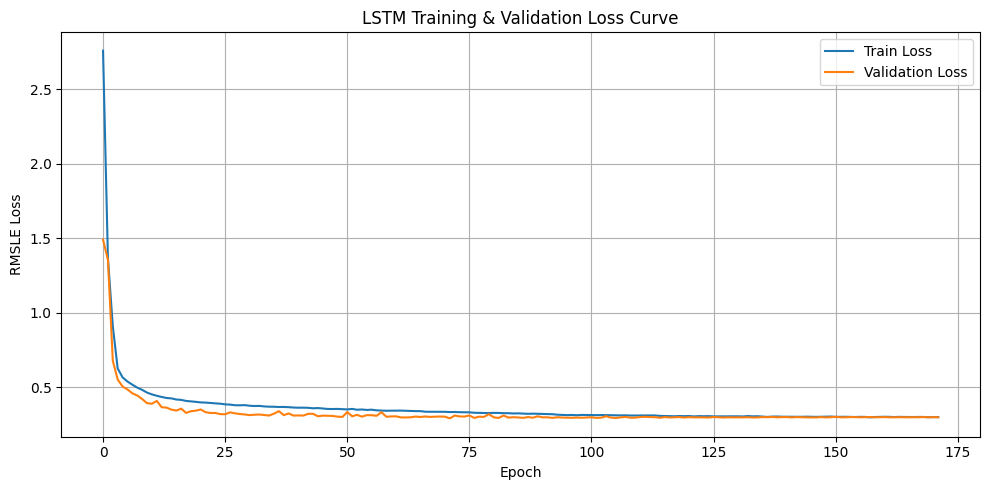

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSLE Loss")
plt.title("LSTM Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

時間序列線圖（預測曲線 vs 真實曲線）

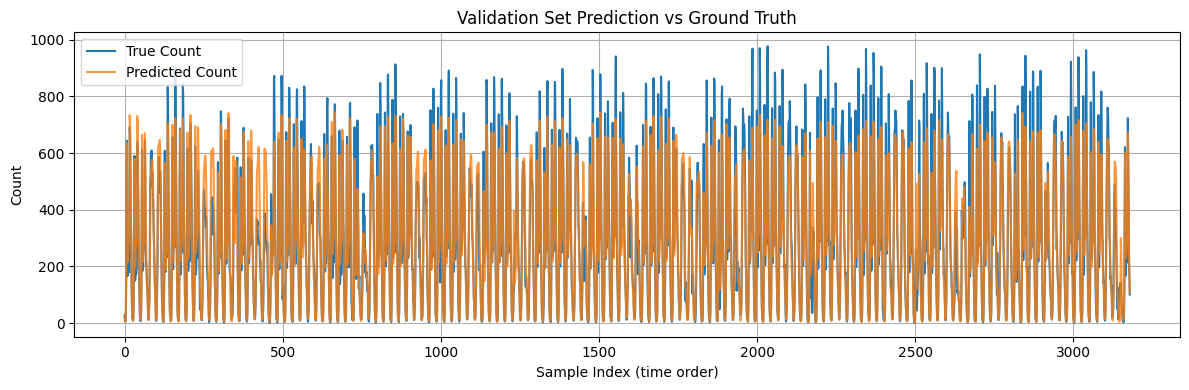

In [18]:
true_series = []
pred_series = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        true_series.extend(torch.expm1(yb).cpu().numpy())
        pred_series.extend(torch.expm1(pred).cpu().numpy())

plt.figure(figsize=(12, 4))
plt.plot(true_series, label="True Count", linewidth=1.5)
plt.plot(pred_series, label="Predicted Count", linewidth=1.5, alpha=0.8)
plt.xlabel("Sample Index (time order)")
plt.ylabel("Count")
plt.title("Validation Set Prediction vs Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


預測值 vs 真實值（散點圖）

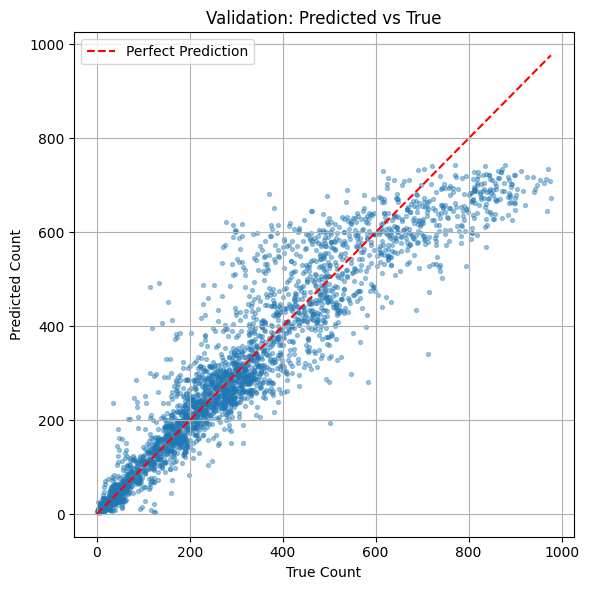

In [19]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        y_true.extend(torch.expm1(yb).cpu().numpy())  # 還原 log1p
        y_pred.extend(torch.expm1(pred).cpu().numpy())

# === 畫散點圖 ===
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=8)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("Validation: Predicted vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5 目標

In [10]:
# === 時間週期特徵函數 ===
def add_time_features(df):
    df["hr_sin"] = np.sin(2 * np.pi * df["hr"] / 24)
    df["hr_cos"] = np.cos(2 * np.pi * df["hr"] / 24)
    df["mnth_sin"] = np.sin(2 * np.pi * df["mnth"] / 12)
    df["mnth_cos"] = np.cos(2 * np.pi * df["mnth"] / 12)
    return df

# === 新增交互特徵函數 ===
def add_interaction_features(df):
    df["hr_x_weekday"] = df["hr"] * df["weekday"]
    df["hr_x_workingday"] = df["hr"] * df["workingday"]
    df["temp_x_hum"] = df["temp"] * df["hum"]
    df["atemp_x_wind"] = df["atemp"] * df["windspeed"]
    return df

# === 特徵欄位設定 ===
basic_features = [
    'season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed'
]
time_features = ['hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos']
interaction_features = ['hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind']
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed', 'hr_x_weekday', 'hr_x_workingday',
                  'temp_x_hum', 'atemp_x_wind']
categorical_cols = ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']

# === 處理 train 資料建立 scaler + 欄位順序基準 ===
df_train = pd.read_csv("train.csv", parse_dates=["dteday"])
df_train["date"] = df_train["dteday"]
df_train = add_time_features(df_train)
df_train = add_interaction_features(df_train)

df_train_encoded = pd.get_dummies(df_train[basic_features + time_features + interaction_features],
                                  columns=categorical_cols, drop_first=False)

scaler = MinMaxScaler()
df_train_encoded[numerical_cols] = scaler.fit_transform(df_train_encoded[numerical_cols])

# === 處理 test 資料 ===
df_test = pd.read_csv("test.csv", parse_dates=["dteday"])
df_test["cnt"] = 0  # 佔位
df_test["date"] = df_test["dteday"]
df_test = add_time_features(df_test)
df_test = add_interaction_features(df_test)

df_test_encoded = pd.get_dummies(df_test[basic_features + time_features + interaction_features],
                                 columns=categorical_cols, drop_first=False)
df_test_encoded[numerical_cols] = scaler.transform(df_test_encoded[numerical_cols])

# === 欄位對齊（避免缺欄、順序錯誤）===
for col in df_train_encoded.columns:
    if col not in df_test_encoded.columns:
        df_test_encoded[col] = 0.0
df_test_encoded = df_test_encoded[df_train_encoded.columns]

# === 合併資料（train + test）建立滑窗序列 ===
df_all = pd.concat([df_train_encoded, df_test_encoded], ignore_index=True)
X_all = df_all.values.astype(np.float32)

# === 載入訓練好的模型 ===
WINDOW = 24
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMRegressor(input_size=X_all.shape[1]).to(DEVICE)
model.load_state_dict(torch.load("best_lstm_model.pt", map_location=DEVICE))
model.eval()

# === 滑動窗口逐步預測 ===
y_preds = []
with torch.no_grad():
    for i in range(len(df_train_encoded), len(df_all)):
        x_window = X_all[i - WINDOW:i]
        x_input = torch.tensor(x_window[np.newaxis, :, :], dtype=torch.float32).to(DEVICE)
        pred_log = model(x_input).item()
        pred_cnt = np.expm1(pred_log)  # 還原 log1p
        y_preds.append(pred_cnt)

# === 產出每日總和預測 ===
df_test["predicted_cnt"] = y_preds
df_test["date"] = df_test["dteday"].dt.date
daily_pred = df_test.groupby("date")["predicted_cnt"].sum().reset_index()

# === 生成提交檔案 ===
submission = pd.read_csv("sample_submission.csv")
assert len(submission) == len(daily_pred), "submission row count mismatch!"
submission["cnt"] = daily_pred["predicted_cnt"].values
submission.to_csv("submission.csv", index=False)
print("✅ 預測完成，已儲存為 submission.csv")

✅ 預測完成，已儲存為 submission.csv


# SHAP 分析

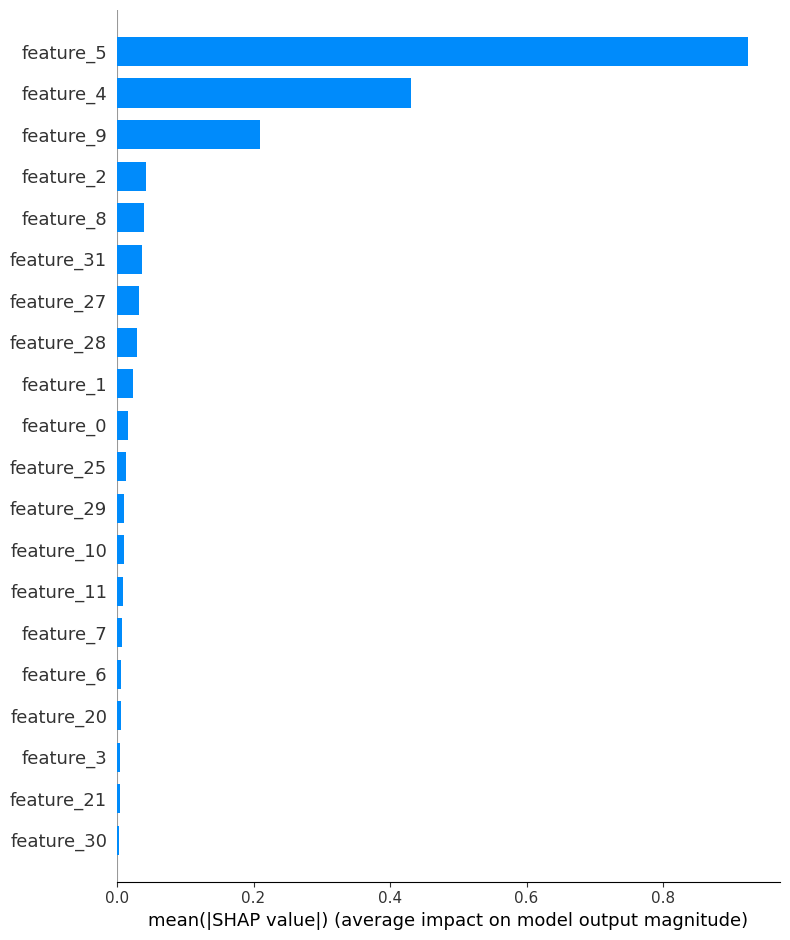

In [20]:
# 1. 取出每筆樣本的最後一小時作為簡化特徵向量（只看 t=72）
X_flat = X_val[:, -1, :]  

# 2. 轉為 numpy array，確保可以傳入 sklearn
X_flat_np = X_flat if isinstance(X_flat, np.ndarray) else X_flat.numpy()
y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.numpy()

# 3. 建一個簡單的模型：Random Forest 來近似 LSTM 輸出
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_flat_np, y_val_np)

# 4. 使用 SHAP 分析這個 RF 模型
explainer = shap.Explainer(model)
shap_values = explainer(X_flat_np)

# 5. 特徵名稱
feature_names = [f'feature_{i}' for i in range(X_flat_np.shape[1])]

# 6. 畫圖
shap.summary_plot(shap_values.values, X_flat_np, feature_names=feature_names, plot_type="bar")

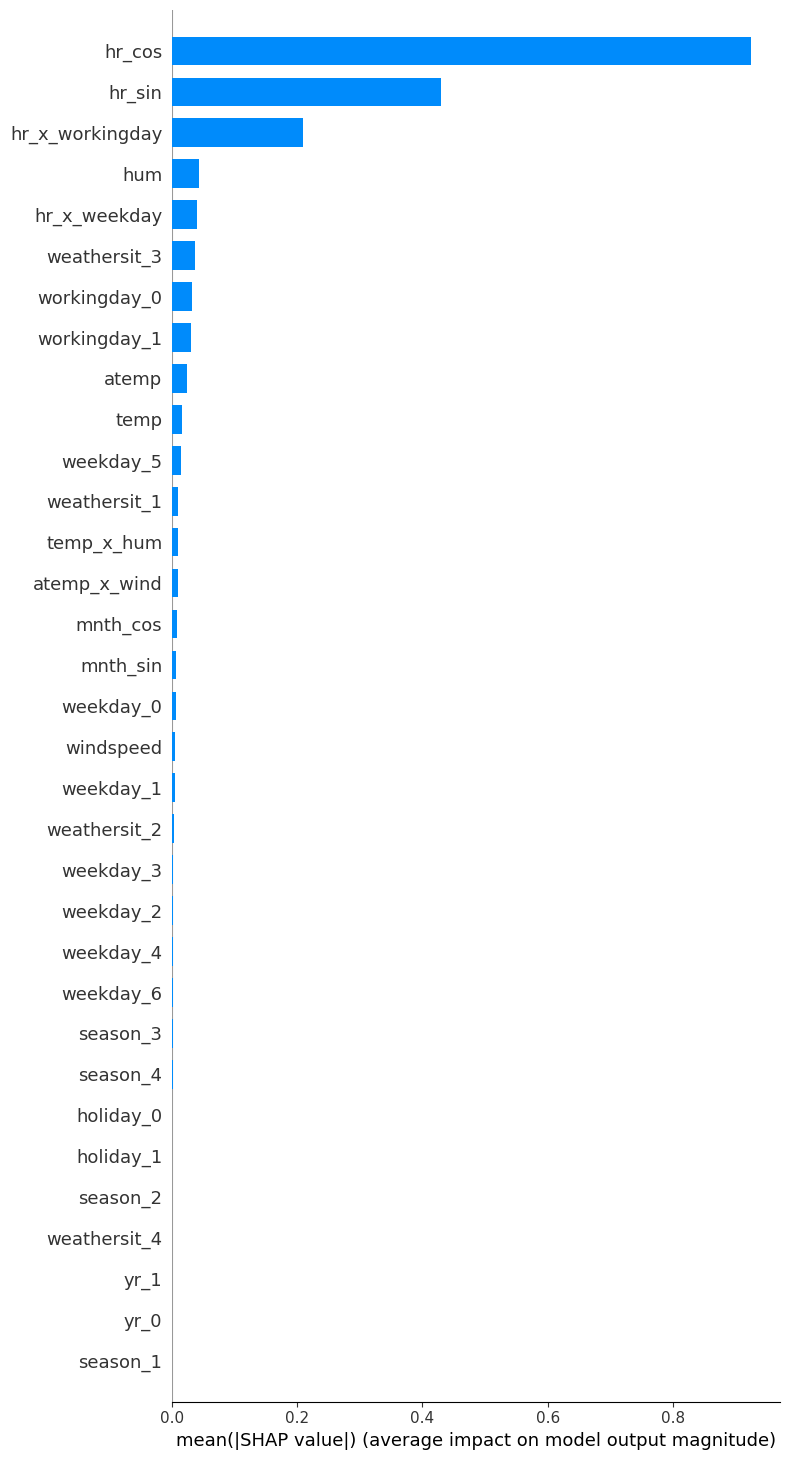

In [21]:
feature_names = np.load("feature_names.npy").tolist()
shap.summary_plot(shap_values.values, X_flat_np, feature_names=feature_names, plot_type="bar", max_display=len(feature_names))